In [20]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [21]:
#constants / QuadCopter dimensions
g = 9.81 # gravity
k = 6.36105*10**-9  # propellar lift coefficient
b = 4.65133*10**-11  # drag coefficient

m_body = 4
l_body = 0.5
w_body = l_body
t_body = 0.1

m_arm = 0.2
l_arm = 0.4

l_rz = 0.05
#1 # z-distance between rotors and center of mass

In [22]:
def body_forces(w1, w2, w3, w4):
    taux = l_rz * k * (-w2**2 + w4**2)
    tauy = l_rz * k * (-w1**2 + w3**2)
    tauz = l_rz * b * (w1**2 - w2**2 + w3**2 - w4**2)

    fz = k * (w1**2 + w2**2 + w3**2 + w4**2)

    return taux, tauy, tauz, fz

In [23]:
#calcs moments of inertia 
m = 4*m_arm + m_body

I_xx_body = 1/12 * m_body*(w_body**2 + t_body**2)
I_yy_body = 1/12 * m_body*(l_body**2 + t_body**2)
I_zz_body = 1/12 * m_body *(w_body**2 + l_body**2)

I_xx_arm = 0
I_yy_arm = 1/12 * m_arm * l_arm**2 + m_arm *(l_arm/2 + l_body/2)**2
I_zz_arm = I_yy_arm

Ixx = 4*I_xx_arm + I_xx_body
Iyy = 4*I_yy_arm + I_yy_body
Izz = 4*I_zz_arm + I_zz_body

In [24]:
def quad_EOM(t, q, taux, tauy, tauz, fz):

    #must be first-order ODES
    '''
    Arguements:
        q : state vector :
        [px, py, pz, vx, vy, vz, phi, theta, psi, 
        omegax, omegay, omegaz, taux, tauy, tauz, fz]

        t : time
        p : various vector parameters : 
        [m, Ixx, Iyy, Izz]
    '''

    px, py, pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz = q

    C_phi = np.cos(phi)
    C_theta = np.cos(theta)
    C_psi = np.cos(psi)
    
    S_phi = np.sin(phi)
    S_theta = np.sin(theta)
    S_psi = np.sin(psi)

    px_dot  = vx*C_psi*C_theta + vy * (S_phi*S_theta*C_psi - S_psi * C_phi) + vz * (S_phi * S_psi + S_theta*C_phi*C_psi)
    py_dot = vx*S_psi*C_theta + vy*(S_phi * S_psi *S_theta + C_phi*C_psi) - vz*(S_phi*C_psi - S_psi*S_theta*C_phi)
    pz_dot = -vx*S_theta + vy*S_phi*C_theta + vz * C_phi * C_theta

    vx_dot = -omegay*vz + omegaz*vy + g*S_theta
    vy_dot = omegax*vz - omegaz*vx - g*S_phi*C_theta
    vz_dot = fz/m - omegax*vy + omegay*vx - g*C_phi*C_theta

    phi_dot = omegax + omegay*S_phi*S_theta/C_theta + omegaz*C_phi*S_theta/C_theta
    theta_dot = omegay*C_phi - omegaz*S_phi
    psi_dot = 1/C_theta * (omegay*S_phi + omegaz*C_phi)

    omegax_dot = 1/Ixx * (Iyy*omegay*omegaz - Izz*omegay*omegaz + taux)
    omegay_dot = 1/Iyy * (-Ixx*omegax*omegaz + Izz*omegax * omegaz + tauy)
    omegaz_dot = 1/Izz * (Ixx*omegax*omegay - Iyy*omegax*omegay+tauz)



    EOM = [px_dot, py_dot, pz_dot, 
           vx_dot, vy_dot, vz_dot,
           phi_dot, theta_dot, psi_dot,
           omegax_dot, omegay_dot, omegaz_dot]
    
    return EOM 

In [25]:
#propeller controls
#for hover, w1=w2=w3=w4
w = np.sqrt(m*g/(k*4))
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

In [26]:
px0 = 0
py0 = 0
pz0 = 1
vx0 = 0
vy0 = 0
vz0 = 0
phi0 = 0
theta0 = 0
psi0 = 0
omegax0 = 0
omegay0 = 0
omegaz0 = 0

t = (0, 60)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-06 ...  6.000e+01  6.000e+01]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 360020
     njev: 0
      nlu: 0

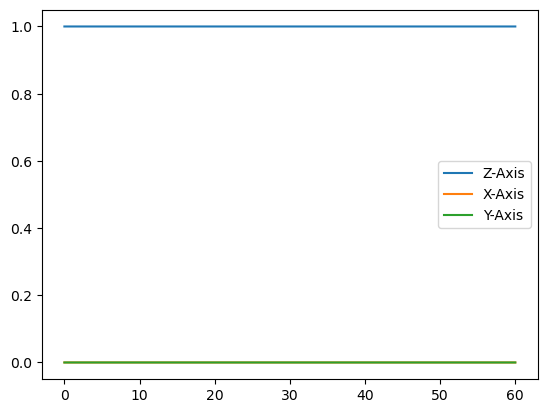

In [27]:
plt.plot(sol.t, sol.y[2], label = 'Z-Axis')
plt.plot(sol.t, sol.y[0], label = 'X-Axis')
plt.plot(sol.t, sol.y[1], label = 'Y-Axis')

plt.legend()
plt.show()

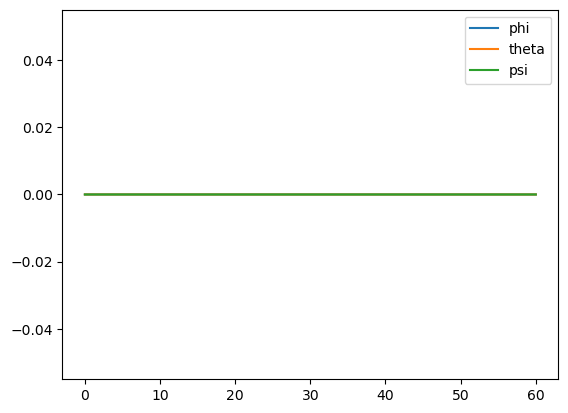

In [28]:
plt.plot(sol.t, sol.y[7], label = 'phi')
plt.plot(sol.t, sol.y[8], label = 'theta')
plt.plot(sol.t, sol.y[9], label = 'psi')

plt.legend()
plt.show()